In [18]:
from matplotlib import pyplot as plt
from intvalpy import IntLinIncR2, Interval, Tol, precision
from intvalpy_fix import IntLinIncR2

precision.extendedPrecisionQ = True

In [21]:
import json

values_x = [-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5]
measurements_each_x_value = 100
shape_1 = 8
shape_2 = 1024
eps = 1 / 16384

left_x = -0.6
right_x = 0.6
bottom_y = -0.6
top_y = 0.6

def load_data(directory, side):
    loaded_data = []
    for i in range(shape_1):
        loaded_data.append([])
        for j in range(shape_2):
            loaded_data[i].append([(values_x[i // measurements_each_x_value], 0) for i in range(measurements_each_x_value * len(values_x))])

    for offset, value_x in enumerate(values_x):
        data = {}
        with open(directory + "/" + str(value_x) + "lvl_side_" + side + "_fast_data.json", "rt") as f:
            data = json.load(f)
        for i in range(shape_1):
            for j in range(shape_2):
                for k in range(len(data["sensors"][i][j])):
                    loaded_data[i][j][offset * measurements_each_x_value + k] = (value_x, data["sensors"][i][j][k])

    return loaded_data

data = load_data("bin/04_10_2024_070_068", "a")

In [20]:
values_x = [1, 3, 5]
measurements_each_x_value = 100
shape_1 = 1
shape_2 = 1
eps = 1 / 8

left_x = 0
right_x = 6
bottom_y = 0
top_y = 6

def generate_data(step = 0.125, shift = 0):
    generated_data = [[]]

    data = [(1, 1 - 2 * step) for i in range(measurements_each_x_value // 4)]
    data.extend([(1, 1 - step) for i in range(measurements_each_x_value // 4)])
    data.extend([(1, 1 + step) for i in range(measurements_each_x_value // 4)])
    data.extend([(1, 1 + 2 * step) for i in range(measurements_each_x_value // 4)])

    data.extend([(3, 3 - 2 * step + shift) for i in range(measurements_each_x_value // 4)])
    data.extend([(3, 3 - step + shift) for i in range(measurements_each_x_value // 4)])
    data.extend([(3, 3 + step + shift) for i in range(measurements_each_x_value // 4)])
    data.extend([(3, 3 + 2 * step + shift) for i in range(measurements_each_x_value // 4)])

    data.extend([(5, 5 - 2 * step) for i in range(measurements_each_x_value // 4)])
    data.extend([(5, 5 - step) for i in range(measurements_each_x_value // 4)])
    data.extend([(5, 5 + step) for i in range(measurements_each_x_value // 4)])
    data.extend([(5, 5 + 2 * step) for i in range(measurements_each_x_value // 4)])

    generated_data[0].append(data)

    return generated_data

data = generate_data(0.2, -0.2)

In [3]:
def amount_of_neg(all_data, coord_1, coord_2):
    x, y = zip(*all_data[coord_1][coord_2])

    # first of all, lets build y_ex and y_in
    y_ex_up = [-float('inf')] * len(values_x)
    y_ex_down = [float('inf')] * len(values_x)
    y_in_up = [-float('inf')] * len(values_x)
    y_in_down = [float('inf')] * len(values_x)

    q_1 = measurements_each_x_value // 4
    q_3 = measurements_each_x_value * 3 // 4 - 1

    for i in range(len(values_x)):
        y_list = list(y[i * measurements_each_x_value: (i + 1) * measurements_each_x_value])
        y_list.sort()
        y_in_down[i] = y_list[q_1] - eps
        y_in_up[i] = y_list[q_3] + eps
        y_ex_up[i] = min(y_list[q_3] + 1.5 * (y_list[q_3] - y_list[q_1]), y_list[-1])
        y_ex_down[i] = max(y_list[q_1] - 1.5 * (y_list[q_3] - y_list[q_1]), y_list[0])

    X_mat = []
    Y_vec = []
    for i in range(len(values_x)):
        x_el = values_x[i]
        # y_ex_up >= X_mat * b >= y_ex_down
        X_mat.append([[x_el, x_el], [1, 1]])
        Y_vec.append([y_in_down[i], y_in_up[i]])

    # now we have matrix X * b = Y, but with some "additional" rows
    # we can walk over all rows and if some of them is less than 0, we can just remove it at all
    X_mat_interval = Interval(X_mat)
    Y_vec_interval = Interval(Y_vec)
    to_remove = []
    b_vec, tol_val, num_iter, calcfg_num, exit_code = Tol.maximize(X_mat_interval, Y_vec_interval)
    # if Tol value is less than 0, we must iterate over all rows and add some changes to Y_vec, so Tol became 0
    for i in range(len(Y_vec)):
        X_mat_small = Interval([X_mat[i]])
        Y_vec_small = Interval([Y_vec[i]])
        value = Tol.value(X_mat_small, Y_vec_small, b_vec)
        if value < 0:
            to_remove.append(i)
    return len(to_remove)

In [8]:
val = [0] * shape_1
for i in range(shape_1):
    val[i] = [0] * shape_2
for j in range(shape_2):
    for i in range(shape_1):
        val[i][j] = amount_of_neg(data, i, j)
        print(i, j, val[i][j])

0 0 6
1 0 8
2 0 6
3 0 7
4 0 5
5 0 5
6 0 7
7 0 6
0 1 7
1 1 7
2 1 6
3 1 7
4 1 5
5 1 7
6 1 6
7 1 6
0 2 4
1 2 7
2 2 5
3 2 7
4 2 6
5 2 7
6 2 5
7 2 6
0 3 4
1 3 5
2 3 3
3 3 8
4 3 5
5 3 7
6 3 5
7 3 5
0 4 4
1 4 4
2 4 3
3 4 9
4 4 5
5 4 7
6 4 4
7 4 5
0 5 4
1 5 7
2 5 4
3 5 10
4 5 6
5 5 7
6 5 4
7 5 3
0 6 0
1 6 6
2 6 0
3 6 9
4 6 6
5 6 7
6 6 0
7 6 4
0 7 0
1 7 7
2 7 0
3 7 10
4 7 7
5 7 8
6 7 0
7 7 4
0 8 3
1 8 7
2 8 0
3 8 10
4 8 5
5 8 8
6 8 0
7 8 5
0 9 3
1 9 6
2 9 3
3 9 9
4 9 5
5 9 7
6 9 0
7 9 4
0 10 3
1 10 5
2 10 0
3 10 10
4 10 4
5 10 7
6 10 0
7 10 3
0 11 3
1 11 5
2 11 3
3 11 9
4 11 5
5 11 8
6 11 0
7 11 0
0 12 3
1 12 6
2 12 0
3 12 11
4 12 3
5 12 7
6 12 0
7 12 0
0 13 0
1 13 4
2 13 3
3 13 10
4 13 3
5 13 7
6 13 4
7 13 0
0 14 0
1 14 4
2 14 0
3 14 10
4 14 7
5 14 6
6 14 4
7 14 5
0 15 0
1 15 8
2 15 0
3 15 10
4 15 8
5 15 8
6 15 3
7 15 6
0 16 3
1 16 5
2 16 3
3 16 8
4 16 5
5 16 5
6 16 5
7 16 6
0 17 3
1 17 7
2 17 3
3 17 8
4 17 5
5 17 6
6 17 6
7 17 6
0 18 3
1 18 6
2 18 3
3 18 7
4 18 7
5 18 5
6 18 7
7 18 6
0 19 5
1

In [22]:
# using Tol
def regression_type_1(points):
    x, y = zip(*points)
    # build intervals out of given points
    weights = [eps] * len(y)
    # we know that y_i = b_0 + b_1 * x_i
    # or, in other words
    # Y = X * b, where X is a matrix with row (x_i, 1), and b is a vector (b_1, b_0)
    X_mat = Interval([[[x_el, x_el], [1, 1]] for x_el in x])
    Y_vec = Interval([[y_el, weights[i]] for i, y_el in enumerate(y)], midRadQ=True)
    # find argmax for Tol
    b_vec, tol_val, num_iter, calcfg_num, exit_code = Tol.maximize(X_mat, Y_vec)
    updated = 0
    if tol_val < 0:
        # if Tol value is less than 0, we must iterate over all rows and add some changes to Y_vec, so Tol became 0
        for i in range(len(Y_vec)):
            X_mat_small = Interval([
                [[x[i], x[i]], [1, 1]]
            ])
            Y_vec_small = Interval([[y[i], weights[i]]], midRadQ=True)
            value = Tol.value(X_mat_small, Y_vec_small, b_vec)
            if value < 0:
                weights[i] = abs(y[i] - (x[i] * b_vec[0] + b_vec[1])) + 1e-8
                updated += 1

    Y_vec = Interval([[y_el, weights[i]] for i, y_el in enumerate(y)], midRadQ=True)
    # find argmax for Tol
    b_vec, tol_val, num_iter, calcfg_num, exit_code = Tol.maximize(X_mat, Y_vec)

    return b_vec, weights, updated

In [23]:
coord_1, coord_2 = 5, 14
data = data[coord_1][coord_2]

(5, 14) 1 0.820057376547264067137788061886582496 0.0142678386129903022659744560301615203 1094


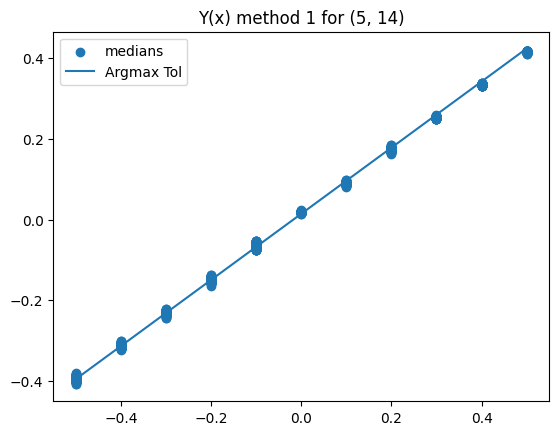

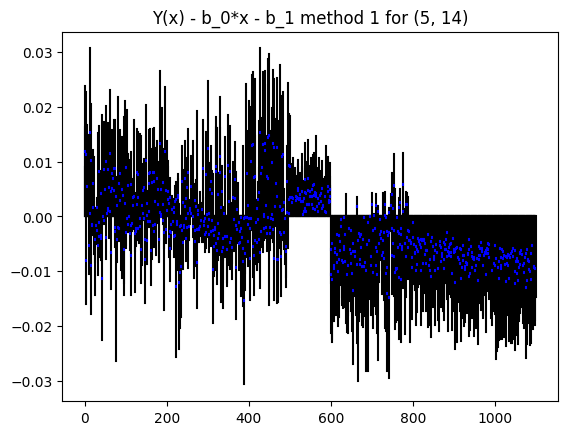

In [27]:
# method 1
b_vec, rads, to_remove = regression_type_1(data)
x, y = zip(*data)
plt.figure()
plt.title("Y(x) method 1 for " + str((coord_1, coord_2)))
plt.scatter(x, y, label="medians")
plt.plot([min(values_x), max(values_x)], [b_vec[1] + b_vec[0] * min(values_x), b_vec[1] + b_vec[0] * max(values_x)], label="Argmax Tol")
plt.legend()
print((coord_1, coord_2), 1, b_vec[0], b_vec[1], to_remove)
plt.savefig("method_1_data_" + str(coord_1) + '_' + str(coord_2) + ".png")

plt.figure()
plt.title("Y(x) - b_0*x - b_1 method 1 for " + str((coord_1, coord_2)))
for i in range(len(y)):
    plt.plot([i, i], [y[i] - rads[i] - b_vec[1] - b_vec[0] * x[i],
                        y[i] + rads[i] - b_vec[1] - b_vec[0] * x[i]], color="k", zorder=1)
    plt.plot([i, i], [y[i] - eps - b_vec[1] - b_vec[0] * x[i],
                        y[i] + eps - b_vec[1] - b_vec[0] * x[i]], color="blue", zorder=2)
plt.savefig("method_1_differences_data_" + str(coord_1) + '_' + str(coord_2) + ".png")

In [25]:
def regression_type_2(points):
    x, y = zip(*points)

    # first of all, lets build y_ex and y_in
    y_ex_up = [-float('inf')] * len(values_x)
    y_ex_down = [float('inf')] * len(values_x)
    y_in_up = [-float('inf')] * len(values_x)
    y_in_down = [float('inf')] * len(values_x)

    q_1 = measurements_each_x_value // 4
    q_3 = measurements_each_x_value * 3 // 4 - 1

    for i in range(len(values_x)):
        y_list = list(y[i * measurements_each_x_value : (i + 1) * measurements_each_x_value])
        y_list.sort()
        y_in_down[i] = y_list[q_1] - eps
        y_in_up[i] = y_list[q_3] + eps
        y_ex_up[i] = min(y_list[q_3] + 1.5 * (y_list[q_3] - y_list[q_1]), y_list[-1])
        y_ex_down[i] = max(y_list[q_1] - 1.5 * (y_list[q_3] - y_list[q_1]), y_list[0])

    X_mat = []
    Y_vec = []
    for i in range(len(values_x)):
        x_el = values_x[i]
        # y_ex_up >= X_mat * b >= y_ex_down
        X_mat.append([[x_el, x_el], [1, 1]])
        Y_vec.append([y_ex_down[i], y_ex_up[i]])
        # y_in_up >= X_mat * b >= y_ex_down
        X_mat.append([[x_el, x_el], [1, 1]])
        Y_vec.append([y_ex_down[i], y_in_up[i]])
        # y_ex_up >= X_mat * b >= y_in_down
        X_mat.append([[x_el, x_el], [1, 1]])
        Y_vec.append([y_in_down[i], y_ex_up[i]])
        # y_in_up >= X_mat * b >= y_in_down
        X_mat.append([[x_el, x_el], [1, 1]])
        Y_vec.append([y_in_down[i], y_in_up[i]])

    # now we have matrix X * b = Y, but with some "additional" rows
    # we can walk over all rows and if some of them is less than 0, we can just remove it at all
    X_mat_interval = Interval(X_mat)
    Y_vec_interval = Interval(Y_vec)
    b_vec, tol_val, num_iter, calcfg_num, exit_code = Tol.maximize(X_mat_interval, Y_vec_interval)
    to_remove = []
    if tol_val < 0:
        # if Tol value is less than 0, we must iterate over all rows and add some changes to Y_vec, so Tol became 0
        for i in range(len(Y_vec)):
            X_mat_small = Interval([X_mat[i]])
            Y_vec_small = Interval([Y_vec[i]])
            value = Tol.value(X_mat_small, Y_vec_small, b_vec)
            if value < 0:
                to_remove.append(i)

        for i in sorted(to_remove, reverse=True):
            del X_mat[i]
            del Y_vec[i]

    X_mat_interval = Interval(X_mat)
    Y_vec_interval = Interval(Y_vec)
    b_vec, tol_val, num_iter, calcfg_num, exit_code = Tol.maximize(X_mat_interval, Y_vec_interval)

    vertices1 = IntLinIncR2(X_mat_interval, Y_vec_interval)
    vertices2 = IntLinIncR2(X_mat_interval, Y_vec_interval, consistency='tol')

    plt.xlabel("b0")
    plt.ylabel("b1")
    b_uni_vertices = []
    for v in vertices1:
        # если пересечение с ортантом не пусто
        if len(v) > 0:
            x, y = v[:, 0], v[:, 1]
            b_uni_vertices += [(x[i], y[i]) for i in range(len(x))]
            plt.fill(x, y, linestyle='-', linewidth=1, color='gray', alpha=0.5, label="Uni")
            plt.scatter(x, y, s=0, color='black', alpha=1)


    b_tol_vertices = []
    for v in vertices2:
        # если пересечение с ортантом не пусто
        if len(v) > 0:
            x, y = v[:, 0], v[:, 1]
            b_tol_vertices += [(x[i], y[i]) for i in range(len(x))]
            plt.fill(x, y, linestyle='-', linewidth=1, color='blue', alpha=0.3, label="Tol")
            plt.scatter(x, y, s=10, color='black', alpha=1)

    plt.scatter([b_vec[0]], [b_vec[1]], s=10, color='red', alpha=1, label="argmax Tol")
    plt.legend()
    return b_vec, (y_in_down, y_in_up), (y_ex_down, y_ex_up), to_remove, b_uni_vertices, b_tol_vertices

(5, 14) 2 0.808379538029691237913342605951023982 0.0115604839491151668583819293588274823 14


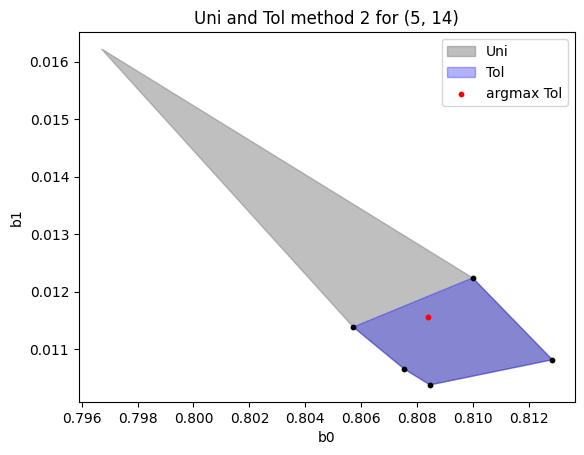

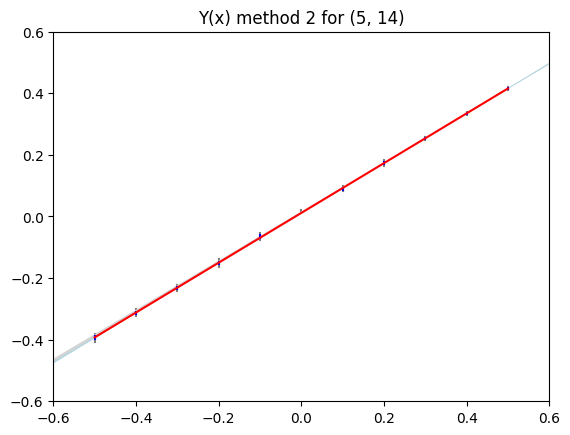

In [ ]:
plt.figure()
plt.title("Uni and Tol method 2 for " + str((coord_1, coord_2)))
b_vec2, y_in, y_ex, to_remove, b_uni_vertices, b_tol_vertices = regression_type_2(data)
print((coord_1, coord_2), 2, b_vec2[0], b_vec2[1], len(to_remove))
plt.savefig("uni_tol_method_2_data_" + str(coord_1) + '_' + str(coord_2) + ".png")
plt.figure()
plt.title("Y(x) method 2 for " + str((coord_1, coord_2)))
for i in range(len(values_x)):
    plt.plot([values_x[i], values_x[i]], [y_ex[0][i], y_ex[1][i]], color="gray", zorder=1)
    plt.plot([values_x[i], values_x[i]], [y_in[0][i], y_in[1][i]], color="blue", zorder=2)

plt.plot([min(values_x), max(values_x)], [b_vec2[1] + b_vec2[0] * min(values_x), b_vec2[1] + b_vec2[0] * max(values_x)], label="Argmax Tol", color="red",
            zorder=1000)

x2 = [left_x] + values_x + [right_x]

for i in range(len(x2) - 1):
    x0 = x2[i]
    x1 = x2[i + 1]
    max_idx = 0
    min_idx = 0
    max_val = b_uni_vertices[0][1] + b_uni_vertices[0][0] * (x0 + x1) / 2
    min_val = b_uni_vertices[0][1] + b_uni_vertices[0][0] * (x0 + x1) / 2
    for j in range(len(b_uni_vertices)):
        val = b_uni_vertices[j][1] + b_uni_vertices[j][0] * (x0 + x1) / 2
        if max_val < val:
            max_idx = j
            max_val = val
        if min_val > val:
            min_idx = j
            min_val = val

    y0_low = b_uni_vertices[min_idx][1] + b_uni_vertices[min_idx][0] * x0
    y1_low = b_uni_vertices[min_idx][1] + b_uni_vertices[min_idx][0] * x1
    y0_hi = b_uni_vertices[max_idx][1] + b_uni_vertices[max_idx][0] * x0
    y1_hi = b_uni_vertices[max_idx][1] + b_uni_vertices[max_idx][0] * x1
    plt.fill([x0, x1, x1, x0], [y0_low, y1_low, y1_hi, y0_hi], facecolor="lightgray", linewidth=0)

    max_idx = 0
    min_idx = 0
    max_val = b_tol_vertices[0][1] + b_tol_vertices[0][0] * (x0 + x1) / 2
    min_val = b_tol_vertices[0][1] + b_tol_vertices[0][0] * (x0 + x1) / 2
    for j in range(len(b_tol_vertices)):
        val = b_tol_vertices[j][1] + b_tol_vertices[j][0] * (x0 + x1) / 2
        if max_val < val:
            max_idx = j
            max_val = val
        if min_val > val:
            min_idx = j
            min_val = val

    y0_low = b_tol_vertices[min_idx][1] + b_tol_vertices[min_idx][0] * x0
    y1_low = b_tol_vertices[min_idx][1] + b_tol_vertices[min_idx][0] * x1
    y0_hi = b_tol_vertices[max_idx][1] + b_tol_vertices[max_idx][0] * x0
    y1_hi = b_tol_vertices[max_idx][1] + b_tol_vertices[max_idx][0] * x1
    plt.fill([x0, x1, x1, x0], [y0_low, y1_low, y1_hi, y0_hi], facecolor="lightblue", linewidth=0)

plt.xlim((left_x, right_x))
plt.ylim((bottom_y, top_y))
plt.savefig("uni_tol_method_2_corridor_joint_dependence_data_" + str(coord_1) + '_' + str(coord_2) + ".png")